This script is to test the signal change in wet versus dry days in 2025.


In [1]:
#Chunk that sloads necessary packages & sets working environment to where the jupyterlab notebook file is 
%load_ext autoreload
%autoreload 2
import gnssvod as gv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pdb
import importlib
import zipfile
import os
import xarray as xr
import glob
import shutil
from gnssvod.hemistats.hemistats import hemibuild
#import georinex as gr
from matplotlib.collections import PatchCollection
import matplotlib.dates as mdates
import shutil
from matplotlib import rcParams
from datetime import datetime, timedelta

In [2]:
#setting time intervals
startday = start=pd.to_datetime('01-01-2025',format='%d-%m-%Y')
timeintervals=pd.interval_range(start=startday, periods=365, freq='D', closed='left')
timeintervals

IntervalIndex([[2025-01-01 00:00:00, 2025-01-02 00:00:00),
               [2025-01-02 00:00:00, 2025-01-03 00:00:00),
               [2025-01-03 00:00:00, 2025-01-04 00:00:00),
               [2025-01-04 00:00:00, 2025-01-05 00:00:00),
               [2025-01-05 00:00:00, 2025-01-06 00:00:00),
               [2025-01-06 00:00:00, 2025-01-07 00:00:00),
               [2025-01-07 00:00:00, 2025-01-08 00:00:00),
               [2025-01-08 00:00:00, 2025-01-09 00:00:00),
               [2025-01-09 00:00:00, 2025-01-10 00:00:00),
               [2025-01-10 00:00:00, 2025-01-11 00:00:00),
               ...
               [2025-12-22 00:00:00, 2025-12-23 00:00:00),
               [2025-12-23 00:00:00, 2025-12-24 00:00:00),
               [2025-12-24 00:00:00, 2025-12-25 00:00:00),
               [2025-12-25 00:00:00, 2025-12-26 00:00:00),
               [2025-12-26 00:00:00, 2025-12-27 00:00:00),
               [2025-12-27 00:00:00, 2025-12-28 00:00:00),
               [2025-12-28 00:00:00, 

In [3]:
#loading csvs
# path
base_path = '/Volumes/coraldelmar/all_data/'

# Read all CSVs
vod_anom12 = pd.read_csv(base_path + 'vod_anom12.csv')
vod_anom13 = pd.read_csv(base_path + 'vod_anom13.csv')
vod_anom17 = pd.read_csv(base_path + 'vod_anom17.csv')
vod_anom57 = pd.read_csv(base_path + 'vod_anom57.csv')
#
ts12 = pd.read_csv(base_path + 'vod_ts_macrocosm12.csv')
ts13 = pd.read_csv(base_path + 'vod_ts_macrocosm13.csv')
ts17 = pd.read_csv(base_path + 'vod_ts_macrocosm17.csv')
ts57 = pd.read_csv(base_path + 'vod_ts_macrocosm57.csv')

#
more12 = pd.read_csv(base_path + 'vod_moreveg12.csv')
less12 = pd.read_csv(base_path + 'vod_lessveg12.csv')
more13 = pd.read_csv(base_path + 'vod_moreveg13.csv')
less13 = pd.read_csv(base_path + 'vod_lessveg13.csv')
more17 = pd.read_csv(base_path + 'vod_moreveg17.csv')
less17 = pd.read_csv(base_path + 'vod_lessveg17.csv')
more57 = pd.read_csv(base_path + 'vod_moreveg57.csv')
less57 = pd.read_csv(base_path + 'vod_lessveg57.csv')

In [4]:
#
plt.rcParams["font.family"] = "Times New Roman"

# loading precipitation data
precip_df = pd.read_excel("/Volumes/coraldelmar/weather.station_alonso/2025/precip05.xlsx")

#parsing date-time
precip_df['Timestamp'] = pd.to_datetime(precip_df['Timestamp'], format='%d/%m/%Y %H:%M', dayfirst=True)

# hour
precip_df['hour'] = precip_df['Timestamp'].dt.hour

# groupping by hour
precip_hourly = precip_df.groupby('hour')['Rain_mm_Tot'].sum()
precip_hourly = precip_hourly.reindex(range(24), fill_value=0)  


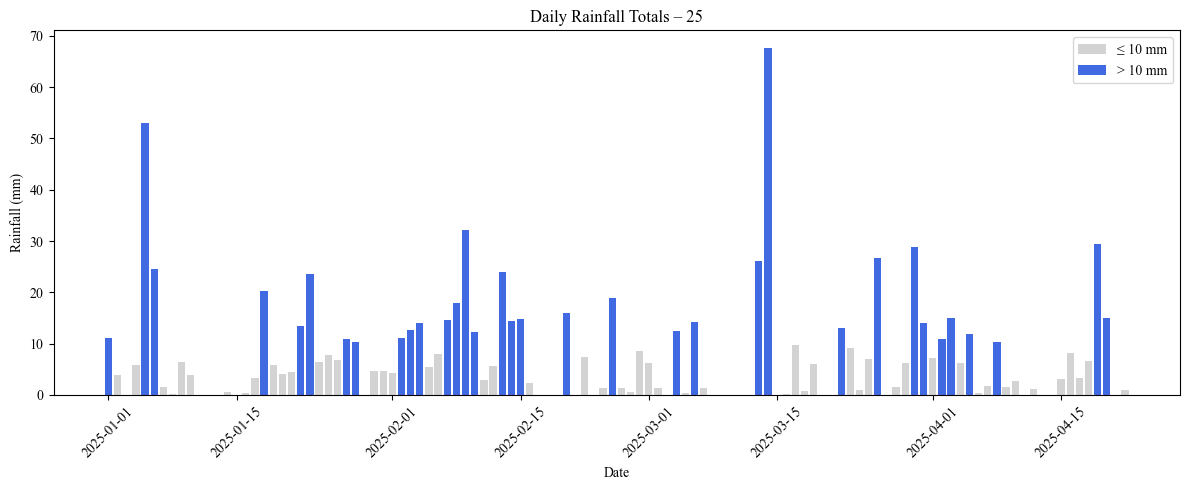

In [5]:
# Parse datetime
precip_df['Timestamp'] = pd.to_datetime(precip_df['Timestamp'], format='%d/%m/%Y %H:%M', dayfirst=True)

# Extract date
precip_df['Date'] = precip_df['Timestamp'].dt.date

# grouping by date
precip_daily = precip_df.groupby('Date')['Rain_mm_Tot'].sum().reset_index()

# separating wet and dry days
dry_days = precip_daily[precip_daily['Rain_mm_Tot'] <= 10]
wet_days = precip_daily[precip_daily['Rain_mm_Tot'] > 10]

# 
fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(dry_days['Date'], dry_days['Rain_mm_Tot'], color='lightgray', label='≤ 10 mm')
ax.bar(wet_days['Date'], wet_days['Rain_mm_Tot'], color='royalblue', label='> 10 mm')
ax.set_title("Daily Rainfall Totals – 25")
ax.set_xlabel("Date")
ax.set_ylabel("Rainfall (mm)")
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Example VOD dates: <DatetimeArray>
['2025-01-14 00:00:00', '2025-01-15 00:00:00', '2025-01-16 00:00:00',
 '2025-01-17 00:00:00', '2025-01-18 00:00:00']
Length: 5, dtype: datetime64[ns]
Wet day matches: 1200
Dry day matches: 1162
wetdry
wet     1200
dry     1162
none    1021
Name: count, dtype: int64


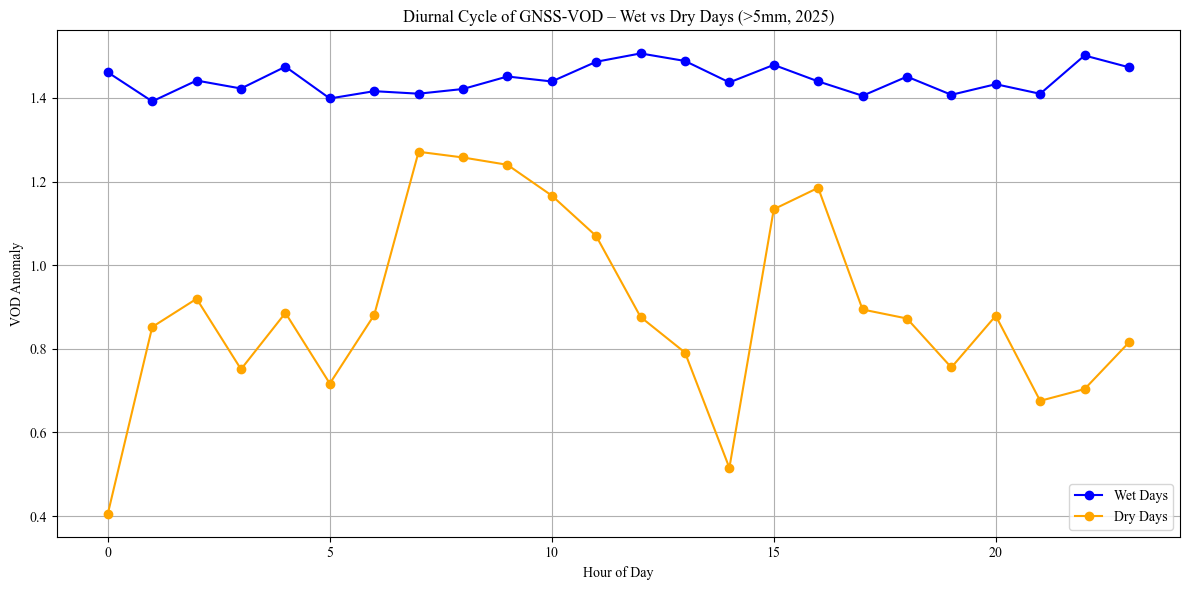

In [6]:
#normalizing timestamp to avoid error
precip_df['Timestamp'] = pd.to_datetime(precip_df['Timestamp'], format='%d/%m/%Y %H:%M', dayfirst=True)
precip_df['Date'] = precip_df['Timestamp'].dt.normalize()

# Daily total precip
precip_daily = precip_df.groupby('Date')['Rain_mm_Tot'].sum().reset_index()

# Define wet/dry days
wet_days = precip_daily[precip_daily['Rain_mm_Tot'] > 5]['Date']
dry_days = precip_daily[precip_daily['Rain_mm_Tot'] <= 5]['Date']

# epoch to date time and renaming as date 
ts17['Epoch'] = pd.to_datetime(ts17['Epoch'])  
ts17.set_index('Epoch', inplace=True)
ts17['Date'] = ts17.index.normalize()

# ensuring only 2025 dates 
ts17 = ts17[ts17['Date'].dt.year == 2025]

# assigning wet and dry dates
ts17['wetdry'] = 'none'
ts17.loc[ts17['Date'].isin(wet_days), 'wetdry'] = 'wet'
ts17.loc[ts17['Date'].isin(dry_days), 'wetdry'] = 'dry'

# checking whether it is correct
print("Example VOD dates:", ts17['Date'].unique()[:5])
print("Wet day matches:", ts17['Date'].isin(wet_days).sum())
print("Dry day matches:", ts17['Date'].isin(dry_days).sum())
print(ts17['wetdry'].value_counts())

# 
wet_data = ts17[ts17['wetdry'] == 'wet']
dry_data = ts17[ts17['wetdry'] == 'dry']

wet_diurnal = wet_data.groupby(wet_data.index.hour)['VOD1_anom'].mean()
dry_diurnal = dry_data.groupby(dry_data.index.hour)['VOD1_anom'].mean()

# 
plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(figsize=(12, 6))
wet_diurnal.plot(ax=ax, marker='o', label='Wet Days', color='blue')
dry_diurnal.plot(ax=ax, marker='o', label='Dry Days', color='orange')
ax.set_title("Diurnal Cycle of GNSS-VOD – Wet vs Dry Days (>5mm, 2025)")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("VOD Anomaly")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


Example VOD dates: <DatetimeArray>
['2025-01-14 00:00:00', '2025-01-15 00:00:00', '2025-01-16 00:00:00',
 '2025-01-17 00:00:00', '2025-01-18 00:00:00']
Length: 5, dtype: datetime64[ns]
Wet day matches: 744
Dry day matches: 1618
wetdry
dry     1618
none    1021
wet      744
Name: count, dtype: int64


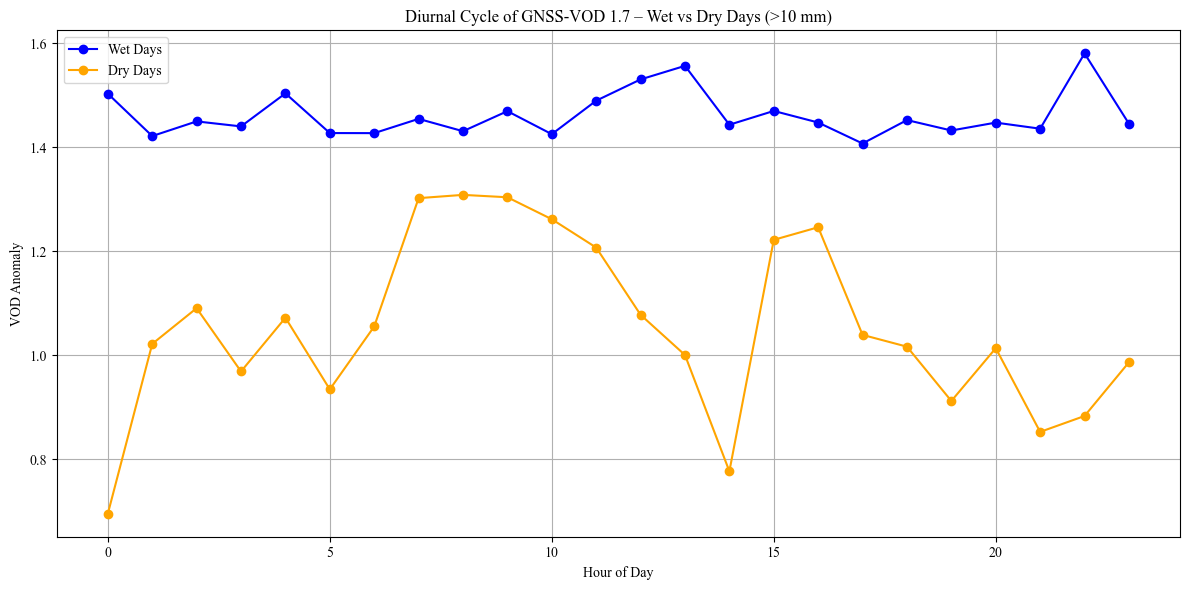

In [7]:
# Define wet/dry days
wet_days = precip_daily[precip_daily['Rain_mm_Tot'] > 10]['Date']
dry_days = precip_daily[precip_daily['Rain_mm_Tot'] <= 10]['Date']

# assigning to new rainfall 
ts17['wetdry'] = 'none'
ts17.loc[ts17['Date'].isin(wet_days), 'wetdry'] = 'wet'
ts17.loc[ts17['Date'].isin(dry_days), 'wetdry'] = 'dry'

# Debugging checks
print("Example VOD dates:", ts17['Date'].unique()[:5])
print("Wet day matches:", ts17['Date'].isin(wet_days).sum())
print("Dry day matches:", ts17['Date'].isin(dry_days).sum())
print(ts17['wetdry'].value_counts())

# 
wet_data = ts17[ts17['wetdry'] == 'wet']
dry_data = ts17[ts17['wetdry'] == 'dry']
wet_diurnal = wet_data.groupby(wet_data.index.hour)['VOD1_anom'].mean()
dry_diurnal = dry_data.groupby(dry_data.index.hour)['VOD1_anom'].mean()

#
plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(figsize=(12, 6))
wet_diurnal.plot(ax=ax, marker='o', label='Wet Days', color='blue')
dry_diurnal.plot(ax=ax, marker='o', label='Dry Days', color='orange')
ax.set_title("Diurnal Cycle of GNSS-VOD 1.7 – Wet vs Dry Days (>10 mm)")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("VOD Anomaly")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


In [8]:
morets17 = pd.read_csv(base_path + 'vod_moretsveg17.csv')
print(morets17.columns)

Index(['Epoch', 'VOD1', 'VOD2', 'Azimuth', 'Elevation', 'CellID', 'VOD1_mean',
       'VOD1_std', 'VOD1_count', 'VOD2_mean', 'VOD2_std', 'VOD2_count',
       'Azimuth_mean', 'Azimuth_std', 'Azimuth_count', 'Elevation_mean',
       'Elevation_std', 'Elevation_count', 'VOD1_anom', 'VOD2_anom'],
      dtype='object')


In [9]:
morets17.head()

,Epoch,VOD1,VOD2,Azimuth,Elevation,CellID,VOD1_mean,VOD1_std,VOD1_count,VOD2_mean,VOD2_std,VOD2_count,Azimuth_mean,Azimuth_std,Azimuth_count,Elevation_mean,Elevation_std,Elevation_count,VOD1_anom,VOD2_anom
0,2025-01-14 16:00:00,0.904400,0.836669,44.312102,41.610828,2468.375796,1.225379,0.645823,298.993631,1.044058,0.732962,298.993631,44.057680,0.677736,298.993631,41.833965,0.421941,298.993631,1.153503,1.149941
1,2025-01-14 20:00:00,-0.561211,-1.208060,40.709239,46.376087,1975.510870,1.249628,0.836022,287.369565,0.937238,0.923565,287.369565,40.657349,0.729733,287.369565,46.531508,0.511679,287.369565,-0.336358,-0.787968
2,2025-01-16 08:00:00,0.388246,0.096051,41.289955,34.908259,2943.725446,1.036674,0.548357,369.988839,0.942457,0.558267,369.988839,41.269784,0.601902,369.988839,34.918699,0.528913,369.988839,0.826053,0.510923
3,2025-01-16 10:00:00,0.302768,0.054094,46.675887,32.684043,2971.606383,1.522687,0.586659,431.031915,1.354121,0.602697,431.031915,46.675358,0.532164,431.031915,32.707742,0.520574,431.031915,0.254563,0.057302
4,2025-01-16 12:00:00,-0.618657,-1.588503,39.700820,51.053279,1481.602459,1.773335,0.934104,308.864754,1.560813,1.077765,308.864754,39.715413,0.724743,308.864754,50.848603,0.457268,308.864754,-0.917510,-1.791987


Example VOD dates: <DatetimeArray>
['2025-01-14 00:00:00', '2025-01-16 00:00:00', '2025-04-14 00:00:00',
 '2025-04-15 00:00:00', '2025-04-16 00:00:00']
Length: 5, dtype: datetime64[ns]
Wet matches: 17
Dry matches: 24
wetdry
none    114
dry      24
wet      17
Name: count, dtype: int64


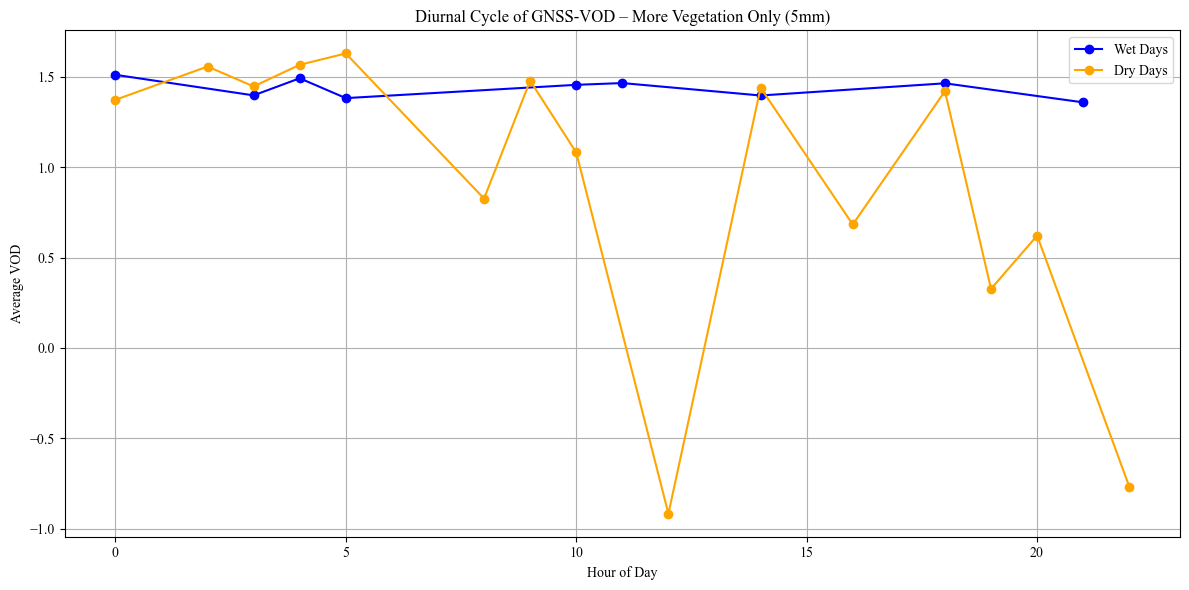

In [10]:
#
wet_days = precip_daily[precip_daily['Rain_mm_Tot'] > 5]['Date']
dry_days = precip_daily[precip_daily['Rain_mm_Tot'] <= 5]['Date']

#
morets17['Epoch'] = pd.to_datetime(morets17['Epoch'])
morets17.set_index('Epoch', inplace=True)
morets17['Date'] = morets17.index.normalize()

# Assign wet/dry label
morets17['wetdry'] = 'none'
morets17.loc[morets17['Date'].isin(wet_days), 'wetdry'] = 'wet'
morets17.loc[morets17['Date'].isin(dry_days), 'wetdry'] = 'dry'

# checks
print("Example VOD dates:", morets17['Date'].unique()[:5])
print("Wet matches:", morets17['Date'].isin(wet_days).sum())
print("Dry matches:", morets17['Date'].isin(dry_days).sum())
print(morets17['wetdry'].value_counts())

# 
wet_data = morets17[morets17['wetdry'] == 'wet']
dry_data = morets17[morets17['wetdry'] == 'dry']
wet_diurnal = wet_data.groupby(wet_data.index.hour)['VOD1_anom'].mean()
dry_diurnal = dry_data.groupby(dry_data.index.hour)['VOD1_anom'].mean()

#
plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(figsize=(12, 6))
wet_diurnal.plot(ax=ax, marker='o', label='Wet Days', color='blue')
dry_diurnal.plot(ax=ax, marker='o', label='Dry Days', color='orange')
ax.set_title("Diurnal Cycle of GNSS-VOD – More Vegetation Only (5mm)")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Average VOD")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

Example VOD dates: <DatetimeArray>
['2025-01-14 00:00:00', '2025-01-16 00:00:00', '2025-04-14 00:00:00',
 '2025-04-15 00:00:00', '2025-04-16 00:00:00']
Length: 5, dtype: datetime64[ns]
Wet matches: 7
Dry matches: 34
wetdry
none    114
dry      34
wet       7
Name: count, dtype: int64


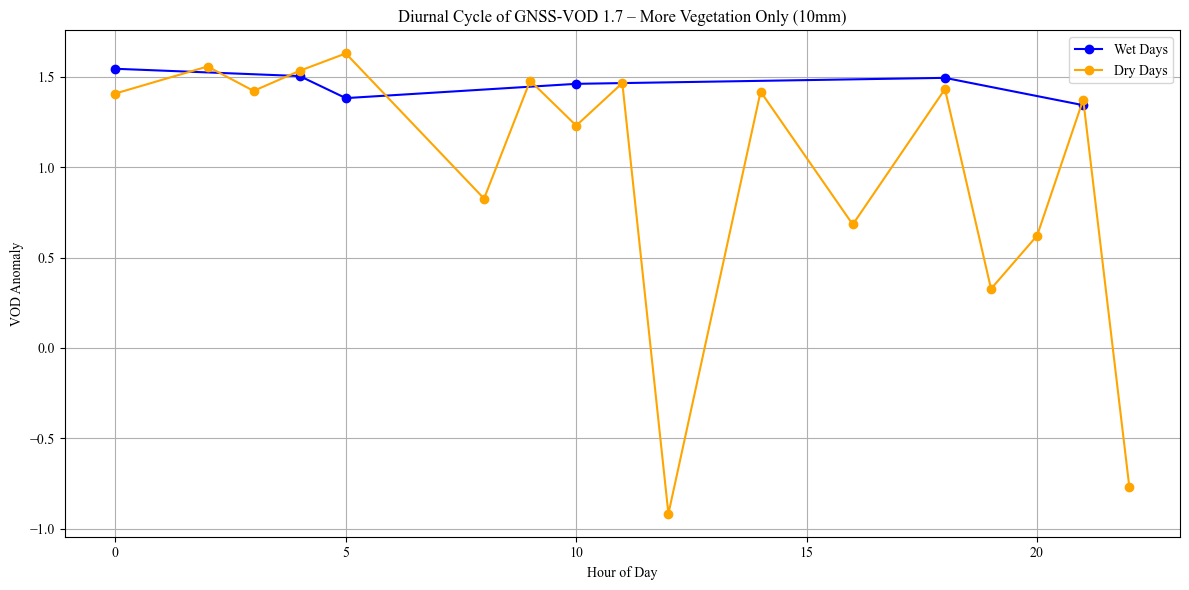

In [11]:
#10mm

wet_days = precip_daily[precip_daily['Rain_mm_Tot'] > 10]['Date']
dry_days = precip_daily[precip_daily['Rain_mm_Tot'] <= 10]['Date']

# Assign wet/dry label
morets17['wetdry'] = 'none'
morets17.loc[morets17['Date'].isin(wet_days), 'wetdry'] = 'wet'
morets17.loc[morets17['Date'].isin(dry_days), 'wetdry'] = 'dry'

# Checks
print("Example VOD dates:", morets17['Date'].unique()[:5])
print("Wet matches:", morets17['Date'].isin(wet_days).sum())
print("Dry matches:", morets17['Date'].isin(dry_days).sum())
print(morets17['wetdry'].value_counts())

# 
wet_data = morets17[morets17['wetdry'] == 'wet']
dry_data = morets17[morets17['wetdry'] == 'dry']
wet_diurnal = wet_data.groupby(wet_data.index.hour)['VOD1_anom'].mean()
dry_diurnal = dry_data.groupby(dry_data.index.hour)['VOD1_anom'].mean()

# 
plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(figsize=(12, 6))
wet_diurnal.plot(ax=ax, marker='o', label='Wet Days', color='blue')
dry_diurnal.plot(ax=ax, marker='o', label='Dry Days', color='orange')
ax.set_title("Diurnal Cycle of GNSS-VOD 1.7 – More Vegetation Only (10mm)")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("VOD Anomaly")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

In [12]:
lessts17= pd.read_csv(base_path + 'vod_lesstsveg17.csv')

Example VOD dates: <DatetimeArray>
['2025-01-14 00:00:00', '2025-01-15 00:00:00', '2025-01-16 00:00:00',
 '2025-01-17 00:00:00', '2025-04-14 00:00:00']
Length: 5, dtype: datetime64[ns]
Wet matches: 79
Dry matches: 91
wetdry
none    383
dry      91
wet      79
Name: count, dtype: int64


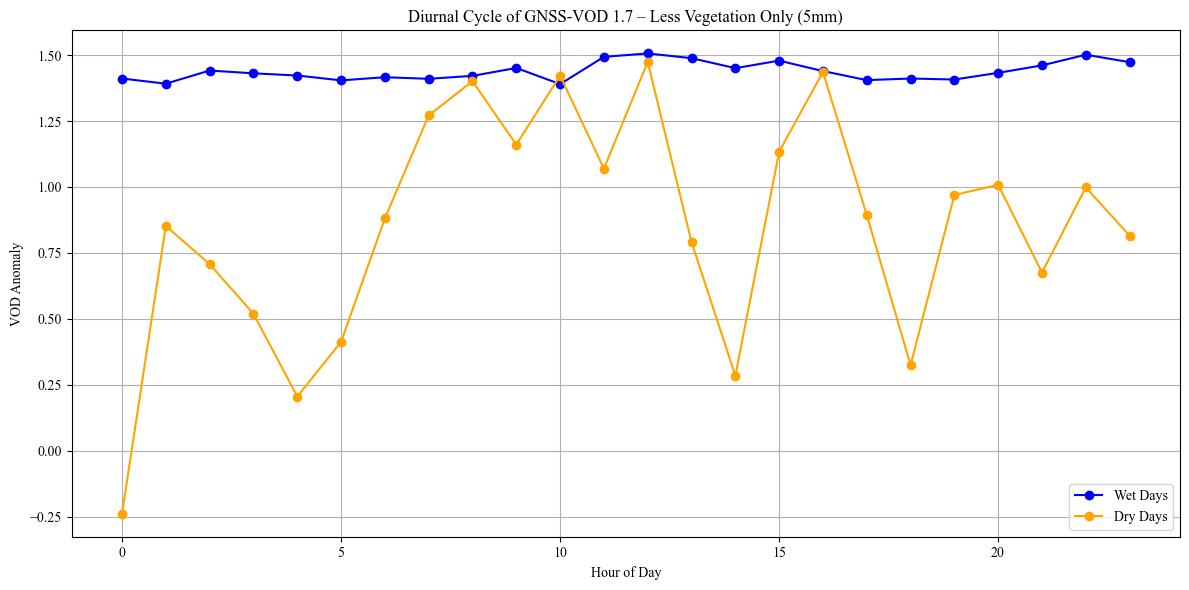

In [13]:
#5mm
wet_days = precip_daily[precip_daily['Rain_mm_Tot'] > 5]['Date']
dry_days = precip_daily[precip_daily['Rain_mm_Tot'] <= 5]['Date']

#
lessts17['Epoch'] = pd.to_datetime(lessts17['Epoch']) 
lessts17.set_index('Epoch', inplace=True)
lessts17['Date'] = lessts17.index.normalize()

# Assign wet/dry label
lessts17['wetdry'] = 'none'
lessts17.loc[lessts17['Date'].isin(wet_days), 'wetdry'] = 'wet'
lessts17.loc[lessts17['Date'].isin(dry_days), 'wetdry'] = 'dry'

# Checks
print("Example VOD dates:", lessts17['Date'].unique()[:5])
print("Wet matches:", lessts17['Date'].isin(wet_days).sum())
print("Dry matches:", lessts17['Date'].isin(dry_days).sum())
print(lessts17['wetdry'].value_counts())

# 
wet_data = lessts17[lessts17['wetdry'] == 'wet']
dry_data = lessts17[lessts17['wetdry'] == 'dry']

wet_diurnal = wet_data.groupby(wet_data.index.hour)['VOD1_anom'].mean()
dry_diurnal = dry_data.groupby(dry_data.index.hour)['VOD1_anom'].mean()

#
plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(figsize=(12, 6))
wet_diurnal.plot(ax=ax, marker='o', label='Wet Days', color='blue')
dry_diurnal.plot(ax=ax, marker='o', label='Dry Days', color='orange')
ax.set_title("Diurnal Cycle of GNSS-VOD 1.7 – Less Vegetation Only (5mm)")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("VOD Anomaly")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

Example VOD dates: <DatetimeArray>
['2025-01-14 00:00:00', '2025-01-15 00:00:00', '2025-01-16 00:00:00',
 '2025-01-17 00:00:00', '2025-04-14 00:00:00']
Length: 5, dtype: datetime64[ns]
Wet matches: 41
Dry matches: 129
wetdry
none    383
dry     129
wet      41
Name: count, dtype: int64


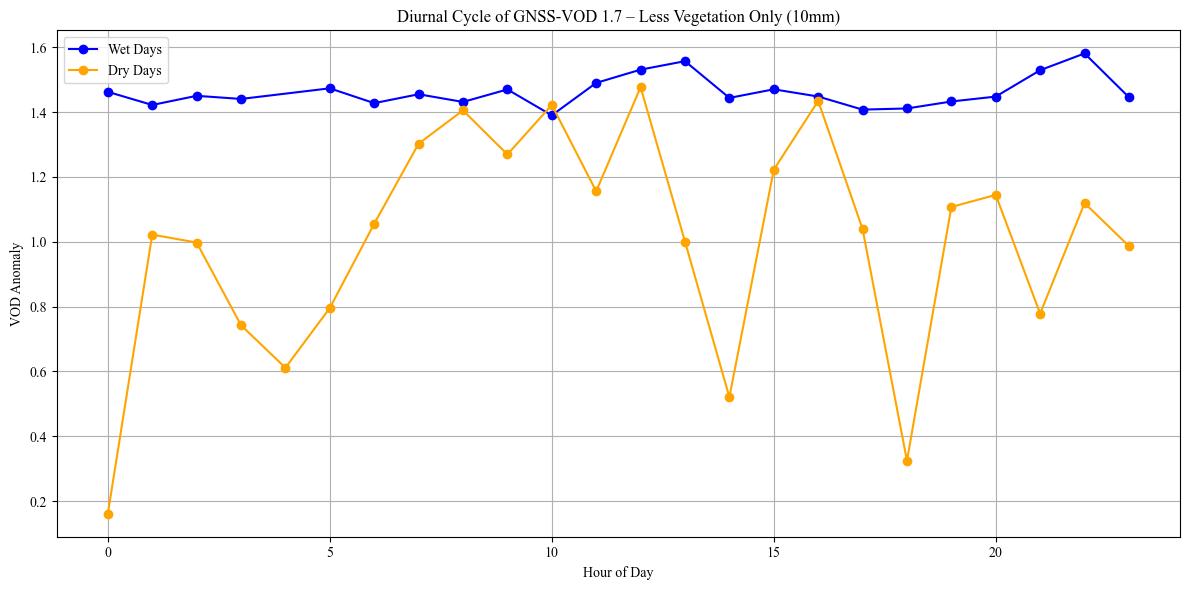

In [14]:
#10mm
wet_days = precip_daily[precip_daily['Rain_mm_Tot'] > 10]['Date']
dry_days = precip_daily[precip_daily['Rain_mm_Tot'] <= 10]['Date']


# Assign wet/dry label
lessts17['wetdry'] = 'none'
lessts17.loc[lessts17['Date'].isin(wet_days), 'wetdry'] = 'wet'
lessts17.loc[lessts17['Date'].isin(dry_days), 'wetdry'] = 'dry'

# Checks
print("Example VOD dates:", lessts17['Date'].unique()[:5])
print("Wet matches:", lessts17['Date'].isin(wet_days).sum())
print("Dry matches:", lessts17['Date'].isin(dry_days).sum())
print(lessts17['wetdry'].value_counts())

#
wet_data = lessts17[lessts17['wetdry'] == 'wet']
dry_data = lessts17[lessts17['wetdry'] == 'dry']
wet_diurnal = wet_data.groupby(wet_data.index.hour)['VOD1_anom'].mean()
dry_diurnal = dry_data.groupby(dry_data.index.hour)['VOD1_anom'].mean()

#
plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(figsize=(12, 6))
wet_diurnal.plot(ax=ax, marker='o', label='Wet Days', color='blue')
dry_diurnal.plot(ax=ax, marker='o', label='Dry Days', color='orange')
ax.set_title("Diurnal Cycle of GNSS-VOD 1.7 – Less Vegetation Only (10mm)")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("VOD Anomaly")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()
